In [1]:
# BASICS

#-----------------------------------------------------------------------------------------------------------
mouse = 'YJ_03'
date = '20220607'
path =  "W:\\swc\\sjones\\users\\Yvonne\\photometry_2AC\\"
saving_folder = path + "processed_data\\" + mouse + '\\'

#-----------------------------------------------------------------------------------------------------------
import sys
sys.path.insert(1, 'C:\\Users\\SJLab_Slice\\Documents\\photometry_analysis\\freely_moving_photometry_analysis')
import os
import joypy
import copy
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle

from scipy.signal import decimate
from utils.plotting import HeatMapParams
from utils.plotting import heat_map_and_mean, plot_one_side, calculate_error_bars
from utils.plotting import get_photometry_around_event
from scipy import stats
from utils.individual_trial_analysis_utils import ZScoredTraces, SessionData, CueAlignedData, CueAlignedSidedData, ChoiceAlignedData
#-----------------------------------------------------------------------------------------------------------

# EXPLANATION

# first trial = trial 0
# last trial of first trial = -1
# nan = no data

#Trial type
#    1 = a trial where high tone is played (usually go left)
#    7 = a trial where low tone is played (usually go right)

#Trial outcome 
#    0 = no reward, incorrect
#    1 = reward (or not being punished in punished trials)
#    3 = no response
             
#Response (final), first / last 
#    1 = left
#    2 = right

# Instance in state: literally counting how often WaitForPoke in this state >> specific for each state name; 
# Max times in state: max number reached for each state X assigned to all state X

# important commands:
# trial_data # the whole table with headings, better than print(trial_data)

In [2]:
restructured_data_filename = mouse + '_' + date + '_' + 'restructured_data.pkl'
trial_data = pd.read_pickle(saving_folder + restructured_data_filename) 
demod_signal = np.load(saving_folder + mouse + '_' + date + "_smoothed_signal.npy" )

<IPython.core.display.Javascript object>


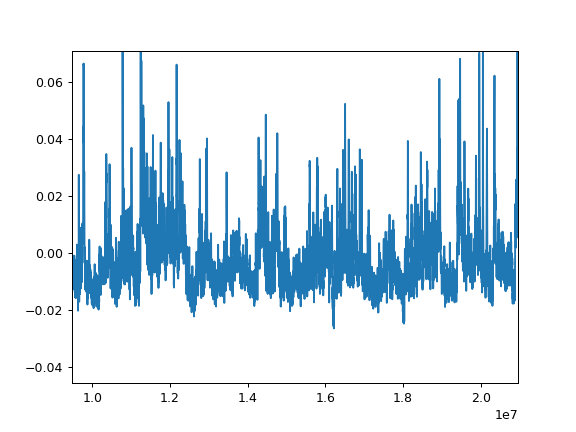

In [3]:
#demod_signal.shape
plt.plot(demod_signal)

<IPython.core.display.Javascript object>


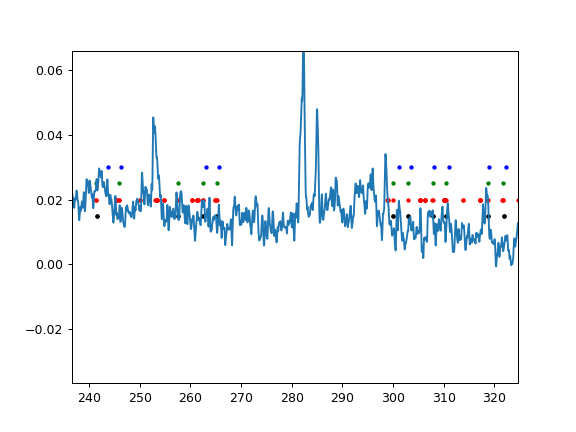

In [8]:

# Time of
choices = trial_data[trial_data['State type'] == 5]['Time end'].values  # wait for resp, end
final_cue = trial_data[(trial_data['State type'] == 3) & (trial_data['Instance in state'] == trial_data['Max times in state'])]['Time end'].values
all_cues = trial_data[(trial_data['State type'] == 3)]['Time end'].values
reward = trial_data[trial_data['State type'] == 8]['Time start'].values 
time = np.linspace(0,demod_signal.shape[0]/10000, demod_signal.shape[0])
center_pokes = trial_data[trial_data['State type'] == 4]['Time end'].values
side_pokes = trial_data[trial_data['State type'] == 5]['Time end'].values
plt.figure()
plt.plot(time, demod_signal)

# currently in seconds
plt.scatter(final_cue, np.ones(final_cue.shape)*0.025, color='g', s=6)
plt.scatter(all_cues, np.ones(all_cues.shape)*0.02, color='r', s=6)
plt.scatter(reward, np.ones(reward.shape)*0.03, color='b', s=6)
plt.scatter(center_pokes, np.ones(center_pokes.shape)*0.015, color ='k', s=6)
plt.scatter(side_pokes, np.ones(side_pokes.shape)*0.015, color ='k', s=6)
#plt.show()

(416,)

In [71]:
trial_data

(5939, 18)

In [61]:
print(trial_data.groupby(['State type', 'State name']).size())

State type  State name            
1.0         TrialStart                 416
2.0         WaitForPoke               1801
3.0         CueDelay                  1801
4.0         WaitForPortOut             416
5.0         WaitForResponse            416
5.5         First incorrect choice      43
6.0         LeftReward                 183
7.0         RightReward                190
8.0         Drinking                   373
8.5         Leaving reward port        257
9.0         Punish                      43
dtype: int64


In [50]:
trial_data


trial_data.values

array([[0.0, 1.0, 1.0, ..., 2.0, 0.0, 0.0],
       [0.0, 1.0, 2.0, ..., 2.0, 0.0, 0.0],
       [0.0, 1.0, 3.0, ..., 2.0, 0.0, 0.0],
       ...,
       [415.0, 7.0, 5.0, ..., 2.0, 0.0, 1.0],
       [415.0, 7.0, 7.0, ..., 2.0, 0.0, 1.0],
       [415.0, 7.0, 8.0, ..., 2.0, 0.0, 1.0]], dtype=object)

In [35]:
#trial_data.values

#print("events in trial 1: " + str(trial_data[trial_data['Trial num']== 0].shape))  # how many events in trial 1?

#print(trial_data.groupby(['Trial num']).size())       # print all trials and for each one how many rows (=events)
#print(trial_data.groupby(['Trial num']).count())
#print('   ')
#print(trial_data.groupby(['State type', 'State name']).size())
#print('   ')
#print(trial_data[trial_data['Trial num']<2].size)  

print(trial_data.groupby(['Trial type']).size())


Trial type
1.0    2802
7.0    3137
dtype: int64


In [39]:
# Look at specific trial:
trial_nr = 12

print("Events in trial " + str(trial_nr) + ": " + str(trial_data[trial_data['Trial num']== trial_nr].shape))
trial_data[trial_data['Trial num']== trial_nr]


Events in trial 12: (10, 18)


,Trial num,Trial type,State type,Instance in state,Max times in state,State name,Time start,Time end,TrialCueDelay,Response,Last response,Last outcome,Trial start,Trial end,Trial outcome,First response,Reward block,First choice correct
153,12.0,1.0,1.0,1.0,1.0,TrialStart,194.6680,194.6780,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
154,12.0,1.0,2.0,1.0,2.0,WaitForPoke,194.6780,196.1505,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
155,12.0,1.0,3.0,1.0,2.0,CueDelay,196.1505,196.1506,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
156,12.0,1.0,2.0,2.0,2.0,WaitForPoke,196.1506,196.1507,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
157,12.0,1.0,3.0,2.0,2.0,CueDelay,196.1507,196.2507,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
158,12.0,1.0,4.0,1.0,1.0,WaitForPortOut,196.2507,196.2772,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
159,12.0,1.0,5.0,1.0,1.0,WaitForResponse,196.2772,197.0852,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
160,12.0,1.0,6.0,1.0,1.0,LeftReward,197.0852,197.0986,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
161,12.0,1.0,8.0,1.0,1.0,Drinking,197.0986,197.0987,0.1,1.0,1.0,1.0,194.668,197.0987,1.0,1.0,0.0,1.0
162,12.0,1.0,8.5,1.0,1.0,Leaving reward port,197.0852,198.2207,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0,1.0


In [41]:
# Look at specific trial:
trial_nr = 8
print("Events in trial " + str(trial_nr) + ": " + str(trial_data[trial_data['Trial num']== trial_nr].shape))
trial_data[trial_data['Trial num']== trial_nr]

Events in trial 8: (8, 18)


,Trial num,Trial type,State type,Instance in state,Max times in state,State name,Time start,Time end,TrialCueDelay,Response,Last response,Last outcome,Trial start,Trial end,Trial outcome,First response,Reward block,First choice correct
118,8.0,1.0,1.0,1.0,1.0,TrialStart,175.5075,175.5175,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
119,8.0,1.0,2.0,1.0,1.0,WaitForPoke,175.5175,183.8700,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
120,8.0,1.0,3.0,1.0,1.0,CueDelay,183.8700,183.9700,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
121,8.0,1.0,4.0,1.0,1.0,WaitForPortOut,183.9700,183.9935,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
122,8.0,1.0,5.0,1.0,1.0,WaitForResponse,183.9935,184.6308,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
123,8.0,1.0,6.0,1.0,1.0,LeftReward,184.6308,184.6442,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
124,8.0,1.0,8.0,1.0,1.0,Drinking,184.6442,184.6443,0.1,1.0,1.0,1.0,175.5075,184.6443,1.0,1.0,0.0,1.0
125,8.0,1.0,8.5,1.0,1.0,Leaving reward port,184.6311,185.5840,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0,1.0


In [59]:
# Look at specific trial:
#print(trial_data[trial_data['Trial type']==7])  

In [44]:
#print(trial_data.groupby(['Trial type', 'Response']).size())

Trial type  Response
1.0         1.0         2435
            2.0          367
7.0         1.0          238
            2.0         2899
dtype: int64


In [46]:
print(trial_data.groupby(['Trial type', 'Last response']).size())

Trial type  Last response
1.0         -1.0                9
             1.0             1342
             2.0             1451
7.0          1.0             1327
             2.0             1810
dtype: int64


In [52]:
print(trial_data.groupby(['Reward block', 'Response']).size())

Reward block  Response
0.0           1.0         2673
              2.0         3266
dtype: int64


In [57]:
# Ask Francesca: 

# trial type: in this trial the mouse is supposed to go left (1) or right (2)? 
# trial outcome: 0 wrong, 1 right

print(trial_data.groupby(['Trial type', 'Trial outcome']).size())
print("  vs.  ")
print(trial_data.groupby(['Trial type', 'Response']).size())
print("    ")
print(trial_data.groupby(['Trial type']).size())

Trial type  Trial outcome
1.0         0.0               367
            1.0              2435
7.0         0.0               238
            1.0              2899
dtype: int64
  vs.  
Trial type  Response
1.0         1.0         2435
            2.0          367
7.0         1.0          238
            2.0         2899
dtype: int64
    
Trial type
1.0    2802
7.0    3137
dtype: int64
